第二题代码

均方误差（MSE）: 0.006324144690838698


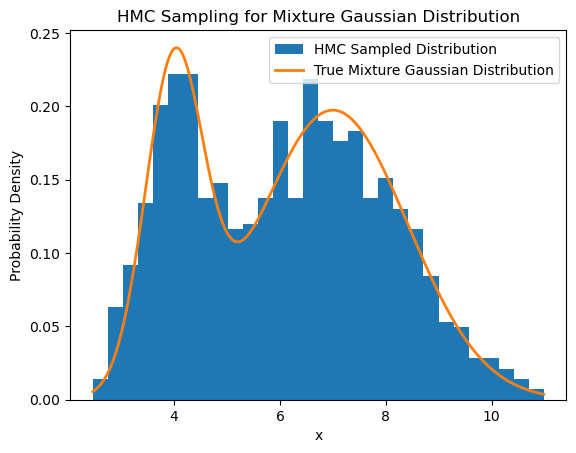

In [9]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


# 目标混合高斯分布的参数
weights = np.array([0.3, 0.7])
means = np.array([4, 7])
stds = np.array([np.sqrt(0.3), np.sqrt(2)])


# 计算混合高斯分布的概率密度函数
def mixture_gaussian_pdf(x):
    pdf_value = 0
    for w, mu, std in zip(weights, means, stds):
        pdf_value += w * norm.pdf(x, mu, std)
    return pdf_value


# 计算势能，即 -log(目标分布的概率密度函数)
def potential_energy(x):
    return -np.log(mixture_gaussian_pdf(x))


# 数值计算势能的梯度
def gradient_potential_energy(x, epsilon=1e-5):
    return (potential_energy(x + epsilon) - potential_energy(x - epsilon)) / (2 * epsilon)


# 蛙跳积分法，模拟哈密顿动力学
def leapfrog(x, p, epsilon, num_steps):
    # 质量矩阵这里设为单位矩阵，所以动量更新比较简单
    M_inv = np.eye(len(x))

    # 更新动量（半步更新）
    p_half = p - 0.5 * epsilon * gradient_potential_energy(x)
    for _ in range(num_steps - 1):
        x = x + epsilon * np.dot(M_inv, p_half)
        p_half = p_half - epsilon * gradient_potential_energy(x)
    x = x + epsilon * np.dot(M_inv, p_half)
    p = p_half - 0.5 * epsilon * gradient_potential_energy(x)
    return x, p


# HMC采样步骤
def hmc_sampling(num_samples, burn_in, x_init, epsilon, num_steps):
    samples = []
    x = x_init
    for _ in range(num_samples + burn_in):
        # 初始化动量
        p = np.random.randn(len(x))

        # 保存当前的状态
        x_current = x.copy()
        p_current = p.copy()

        # 模拟哈密顿动力学
        x_new, p_new = leapfrog(x_current, p_current, epsilon, num_steps)

        # 计算新旧哈密顿量
        H_current = potential_energy(x_current) + 0.5 * np.sum(p_current ** 2)
        H_new = potential_energy(x_new) + 0.5 * np.sum(p_new ** 2)

        # Metropolis-Hastings接受/拒绝步骤
        if np.random.rand() < np.exp(-(H_new - H_current)):
            x = x_new

        if _ >= burn_in:
            samples.append(x)
    return np.array(samples)


# 初始值设置
x_init = np.array([4])  # 初始位置，可以根据实际调整
epsilon = 0.1  # 步长，可调整
num_steps = 10  # 蛙跳积分的步数，可调整
num_samples = 1000  # 采样数量
burn_in = 500  # 预烧期，去除初始阶段不稳定的样本

# 执行HMC采样
samples = hmc_sampling(num_samples, burn_in, x_init, epsilon, num_steps)

# 计算采样分布的均值和方差
sample_mean = np.mean(samples)
sample_var = np.var(samples)

# 计算目标混合高斯分布的理论均值和方差
theoretical_mean = np.sum(weights * means)
theoretical_var = np.sum(weights * (stds ** 2 + means ** 2)) - theoretical_mean ** 2

# 计算均方误差（MSE）
mse_mean = ((sample_mean - theoretical_mean) ** 2)
mse_var = ((sample_var - theoretical_var) ** 2)
mse = mse_mean + mse_var
print(f"均方误差（MSE）: {mse}")

# 可视化采样结果（可选）
plt.hist(samples, bins=30, density=True, label='HMC Sampled Distribution')
x_range = np.linspace(np.min(samples), np.max(samples), 1000)
pdf_values = [mixture_gaussian_pdf(x) for x in x_range]
plt.plot(x_range, pdf_values, label='True Mixture Gaussian Distribution', lw=2)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('HMC Sampling for Mixture Gaussian Distribution')
plt.legend()
plt.show()
                                                                                                                                                                            

五、（20分）利用变分贝叶斯模型用于识别垃圾邮件和非垃圾邮件，参考数据库：http://www.aueb.gr/users/ion/data/enron-spam/
用了两种方法：1）多项式贝叶斯分类器 2）变分贝叶斯模型

法1：使用多项式贝叶斯分类器，准确率很高

In [1]:
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# 数据路径
data_dir = './enron1'
ham_dir = os.path.join(data_dir, 'ham')
spam_dir = os.path.join(data_dir, 'spam')

# 读取邮件文件
def load_email_data(directory, label):
    emails = []
    labels = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r', encoding='latin1') as f:
            emails.append(f.read())
            labels.append(label)
    return emails, labels

# 加载垃圾邮件和非垃圾邮件
ham_emails, ham_labels = load_email_data(ham_dir, 0)  # 0代表非垃圾邮件
spam_emails, spam_labels = load_email_data(spam_dir, 1)  # 1代表垃圾邮件

# 合并数据
emails = ham_emails + spam_emails
labels = ham_labels + spam_labels

# 切分数据集
X_train, X_test, y_train, y_test = train_test_split(emails, labels, test_size=0.2, random_state=13)

# TF-IDF特征提取
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# 使用多项式贝叶斯分类器
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# 预测
y_pred = nb_classifier.predict(X_test_tfidf)

# 输出结果
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9468599033816425
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       738
           1       0.88      0.94      0.91       297

    accuracy                           0.95      1035
   macro avg       0.93      0.94      0.94      1035
weighted avg       0.95      0.95      0.95      1035



法2：使用变分贝叶斯模型，准确率较差

In [48]:
import os
import pymc as pm
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 数据路径
data_dir = './enron1'
ham_dir = os.path.join(data_dir, 'ham')
spam_dir = os.path.join(data_dir, 'spam')

# 读取邮件文件
def load_email_data(directory, label):
    emails = []
    labels = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r', encoding='latin1') as f:
            emails.append(f.read())
            labels.append(label)
    return emails, labels

# 加载垃圾邮件和非垃圾邮件
ham_emails, ham_labels = load_email_data(ham_dir, 0)
spam_emails, spam_labels = load_email_data(spam_dir, 1)

# 合并数据
emails = ham_emails + spam_emails
labels = ham_labels + spam_labels

# 切分数据集
X_train, X_test, y_train, y_test = train_test_split(emails, labels, test_size=0.2, random_state=13)

# TF-IDF特征提取
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 将稀疏矩阵转换为稠密矩阵并转为float32类型
X_train_tfidf = X_train_tfidf.toarray().astype(np.float32)
X_test_tfidf = X_test_tfidf.toarray().astype(np.float32)

# 构建变分贝叶斯分类模型
with pm.Model() as model:
    # 定义模型参数
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=(X_train_tfidf.shape[1],))  # X_train_tfidf.shape[1] 特征数
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # 定义线性模型
    mu = alpha + pm.math.dot(X_train_tfidf, beta)
    
    # 定义观测数据
    y_obs = pm.Bernoulli('y_obs', p=pm.math.sigmoid(mu), observed=y_train)

    # 使用ADVI进行变分推断
    vi = pm.ADVI()
    approx = vi.fit(n=10000)

    # 采样后验分布
    trace = approx.sample()

    # 对测试集进行预测
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['alpha','beta'], model=model)

# 从后验预测中获取alpha和beta样本
alpha_samples = posterior_predictive['posterior_predictive']['alpha']
beta_samples = posterior_predictive['posterior_predictive']['beta']
alpha_samples_array = alpha_samples.values
beta_samples_array = beta_samples.values

alpha_samples_array = np.squeeze(alpha_samples_array)
beta_samples_array = np.squeeze(beta_samples_array)

a = alpha_samples_array[np.newaxis, :]
Xb = np.dot(X_test_tfidf, beta_samples_array.T)

# 计算测试集的预测概率
y_pred_prob = np.mean(1 / (1 + np.exp(-(a + Xb))), axis=1)
y_pred = (y_pred_prob > 0.5).astype(int)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.3401


七、（20分）利用分类模型数据分类。数据来源：http://archive.ics.uci.edu/ml/datasets/Iris：1. 数据集自行网上搜索；2. 实现包含SVM、神经网络和集成学习至少三种模型；3. 不同模型的结果与效率进行比较。

Model Comparison:
SVM - Accuracy: 0.9667, Precision: 0.9704, Recall: 0.9667, F1-score: 0.9668
  Training Time: 0.0000s, Prediction Time: 0.0000s
NN (MLP) - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
  Training Time: 0.3995s, Prediction Time: 0.0000s
RF - Accuracy: 0.9667, Precision: 0.9704, Recall: 0.9667, F1-score: 0.9668
  Training Time: 0.1165s, Prediction Time: 0.0167s


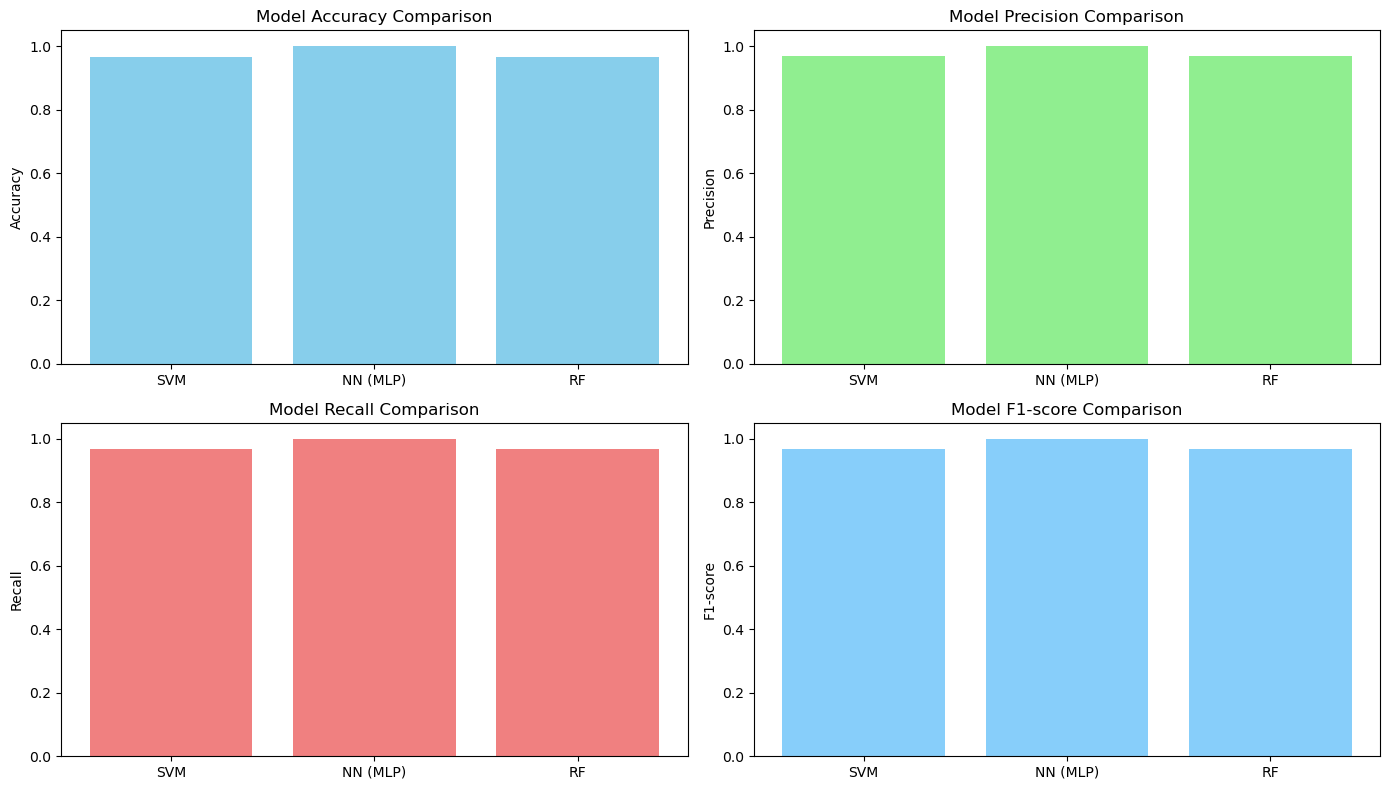

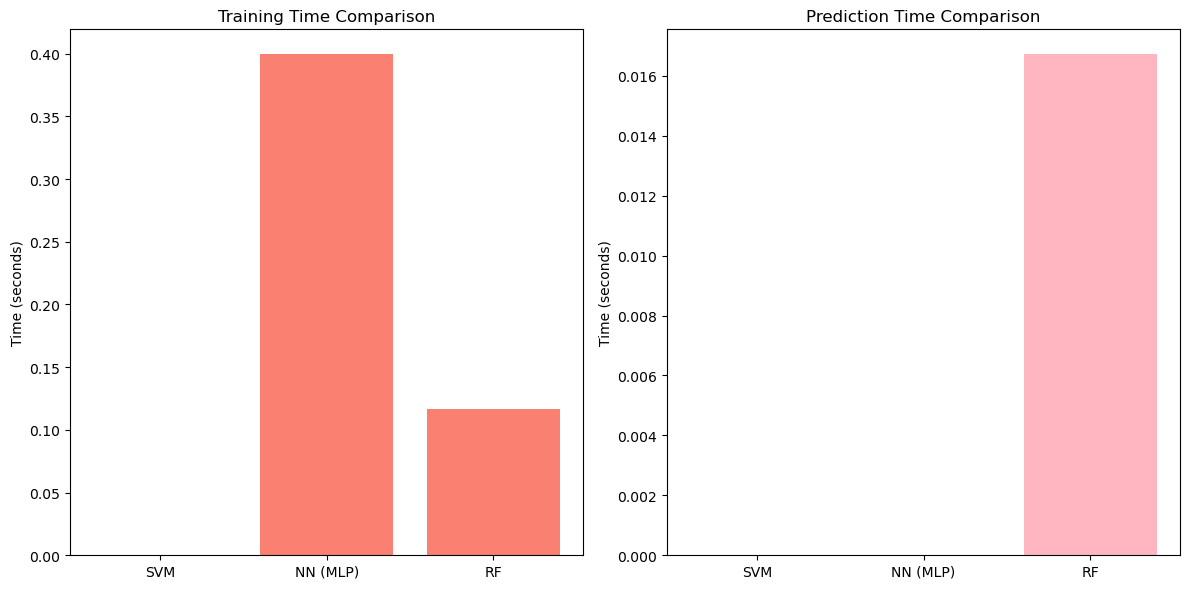

In [14]:
from ucimlrepo import fetch_ucirepo 
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 获取数据集
iris = fetch_ucirepo(id=53) 
X = iris.data.features 
y = iris.data.targets 

y = y.values.ravel()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# 特征标准化（SVM 和神经网络对标准化敏感）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 模型训练与评估
def evaluate_model(model, X_train, y_train, X_test, y_test):
    try:
        # 训练模型
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        # 预测
        start_time = time.time()
        y_pred = model.predict(X_test)
        prediction_time = time.time() - start_time

        # 计算各项评估指标
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        return accuracy, precision, recall, f1, training_time, prediction_time
    except Exception as e:
        print(f"Error while evaluating model {model}: {e}")
        return None, None, None, None, None, None

# 模型1：支持向量机（SVM）
svm_model = SVC(kernel='linear')
svm_results = evaluate_model(svm_model, X_train, y_train, X_test, y_test)

# 模型2：神经网络（MLP）
nn_model = MLPClassifier(hidden_layer_sizes=(5,), max_iter=10000, random_state=23)
nn_results = evaluate_model(nn_model, X_train, y_train, X_test, y_test)

# 模型3：集成学习（随机森林）
rf_model = RandomForestClassifier(n_estimators=100, random_state=23)
rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

# 输出比较结果
print("Model Comparison:")
models = ['SVM', 'NN (MLP)', 'RF']
for model, result in zip(models, [svm_results, nn_results, rf_results]):
    if result[0] is not None:
        accuracy, precision, recall, f1, train_time, pred_time = result
        print(f"{model} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        print(f"  Training Time: {train_time:.4f}s, Prediction Time: {pred_time:.4f}s")
    else:
        print(f"{model} - Evaluation failed!")

# 比较准确率、训练时间和预测时间
accuracies = [svm_results[0], nn_results[0], rf_results[0]]
precisions = [svm_results[1], nn_results[1], rf_results[1]]
recalls = [svm_results[2], nn_results[2], rf_results[2]]
f1_scores = [svm_results[3], nn_results[3], rf_results[3]]
training_times = [svm_results[4], nn_results[4], rf_results[4]]
prediction_times = [svm_results[5], nn_results[5], rf_results[5]]

# 创建图形
plt.figure(figsize=(14, 8))

# 准确率比较图
plt.subplot(2, 2, 1)
plt.bar(models, accuracies, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')

# 精确度比较图
plt.subplot(2, 2, 2)
plt.bar(models, precisions, color='lightgreen')
plt.title('Model Precision Comparison')
plt.ylabel('Precision')

# 召回率比较图
plt.subplot(2, 2, 3)
plt.bar(models, recalls, color='lightcoral')
plt.title('Model Recall Comparison')
plt.ylabel('Recall')

# F1-score比较图
plt.subplot(2, 2, 4)
plt.bar(models, f1_scores, color='lightskyblue')
plt.title('Model F1-score Comparison')
plt.ylabel('F1-score')

plt.tight_layout()
plt.show()

# 训练时间和预测时间比较图
plt.figure(figsize=(12, 6))

# 训练时间比较
plt.subplot(1, 2, 1)
plt.bar(models, training_times, color='salmon')
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')

# 预测时间比较
plt.subplot(1, 2, 2)
plt.bar(models, prediction_times, color='lightpink')
plt.title('Prediction Time Comparison')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()